  # Apply encoder to morphological profiles to get latent space representations :

# Setup

In [1]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['../','../../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import numpy as np
import pandas as pd
import scipy
# import torch
# import torch.nn.functional as F
# from torchinfo import summary
# torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
# torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)



pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ../
insert ../../..
['../../..', '../', '/home/kevin/WSL-shared/cellpainting/cj-datasets/Notebooks-TPSA_Classification', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [3]:
# import snnl.utils as utils
# from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle

from src.utils.utils_cellpainting import (model_selection, balance_datasets, label_counts, compute_metrics,
                                        plots_from_estimator, plots_from_predictions)
from src.utils.jcp_datasets import project_datasets, display_project_datasets

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [4]:
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as sps

import sklearn.metrics as skm
import sklearn.utils.random as skr
from scipy.spatial.distance import pdist, squareform, euclidean

# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Models
from xgboost import XGBClassifier, XGBRegressor

import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder

# K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set,
# and its prediction is computed with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
from sklearn.model_selection._split import check_cv

from sklearn.pipeline import Pipeline

# Make a scorer from a performance metric or loss function. This factory function wraps scoring
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score,
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).
from sklearn.metrics import make_scorer

# regression matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# classification metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
from sklearn.preprocessing import StandardScaler


In [6]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}  ")


2024-12-06 16:19:33,579 - __main__ - INFO: -  Excution started : 2024_12_06_16:19:33 
2024-12-06 16:19:33,581 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2024-12-06 16:19:33,582 - __main__ - INFO: -  Pandas version: 2.2.2  


In [7]:

ds = project_datasets(output_path = '../output_10162023/')
display_project_datasets(ds)

 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ../output_10162023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ../output_10162023/compound_metadata_smiles.csv
          + TPSA                             : ../output_10162023/compound_metadata_tpsa.csv
          + TPSA

## Helper routines

In [8]:
sample_idxs = skr.sample_without_replacement(n_population=100, n_samples= 10 )

rng = np.random.default_rng()

indxs = rng.choice(100, [10,10], replace = False)
indxs

array([[49, 69, 75, 78, 61, 50, 28, 81, 63, 52],
       [98, 10, 84, 66, 90, 21, 55, 40, 82, 20],
       [92, 12, 65, 88, 99, 25, 29, 48, 22, 14],
       [15, 77,  7, 56, 44, 86,  1, 16,  4, 83],
       [67, 30, 53, 59,  2,  9, 38,  8, 76, 71],
       [87, 57, 27, 23, 42, 19, 37,  5, 33, 85],
       [11, 35, 72, 89, 64, 18, 80, 13, 96, 36],
       [24, 34,  0, 26, 41, 46, 47, 51, 93, 39],
       [45,  3, 79, 60, 97, 95, 62, 74, 32, 58],
       [31, 70, 17, 68, 73, 54, 43,  6, 94, 91]])

### main(args)

In [9]:
WANDB_ACTIVE  = False
DATE          = 'yyyymmdd-hhmm'
# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_240709_2235_LAST_ep_705.pt"
# RUN_ID        = "jzt6ecjz"
PROFILES_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"
EMBEDDINGS_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
FINGERPRINTS_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"
MODEL_SAVE_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_tpsa_models/embedding_models"

LATENT_DIM = 1471
METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well'  , 'Metadata_JCP2022', 
                 'Metadata_Hash'  , 'Metadata_Bin'  , 'Metadata_TPSA' , 'Metadata_lnTPSA', 'Metadata_log10TPSA', 
                 'Metadata_Permiation']

# METADATA_COLS += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
INPUT_COLS = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))
print(INPUT_COLS)

## AUTOENCODER RUNMODE 
# AE_RUNMODE = "snnl"
# AE_RUNMODE = 'base'
## 
# AE_DATETIME = "20240906_2201"     # SNNL, CPB = 600, Latent 150, WD = 0.001, SNN Factor 3
# AE_DATETIME = "20240917_2004"     # SNNL, CPB = 600, Latent 250, WD = 0.001, SNN Factor 3
##
# AE_CKPTTYPE = "BEST"
# AE_CKPTTYPE = "LAST"
# df_header = pd.read_csv(HEADER_FILE).columns.to_list()
# header_cols

11
1482


In [11]:
# = utils.load_model_from_ckpt(model, ex_mode, ex_timestamp, ex_title, epochs, ex_cpb, ex_factor )

FINGERPRINTS_TRAINING_FILE   = f"3sample_pharmacophores_{INPUT_COLS}_HashOrder_training.csv"
FINGERPRINTS_VALIDATION_FILE = f"3sample_pharmacophores_{INPUT_COLS}_HashOrder_validation.csv"
FINGERPRINTS_TEST_FILE       = f"3sample_pharmacophores_{INPUT_COLS}_HashOrder_test.csv"

print(FINGERPRINTS_TRAINING_FILE)
print(FINGERPRINTS_VALIDATION_FILE)
print(FINGERPRINTS_TEST_FILE)

PROFILES_TRAINING_FILE   = f'3sample_profiles_{INPUT_COLS}_HashOrder_training.csv'
PROFILES_VALIDATION_FILE = f'3sample_profiles_{INPUT_COLS}_HashOrder_validation.csv'
PROFILES_TEST_FILE       = f'3sample_profiles_{INPUT_COLS}_HashOrder_test.csv'

print()
print(PROFILES_TRAINING_FILE)
print(PROFILES_VALIDATION_FILE)
print(PROFILES_TEST_FILE)

# EMBEDDINGS_TRAINING_FILE   = f'3smpl_prfl_profiles_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_training.csv'
# EMBEDDINGS_VALIDATION_FILE = f'3smpl_prfl_profiles_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_validation.csv'
# EMBEDDINGS_TEST_FILE       = f'3smpl_prfl_profiles_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_test.csv'

# print()
# print(EMBEDDINGS_TRAINING_FILE)
# print(EMBEDDINGS_VALIDATION_FILE)
# print(EMBEDDINGS_TEST_FILE)

3sample_pharmacophores_1482_HashOrder_training.csv
3sample_pharmacophores_1482_HashOrder_validation.csv
3sample_pharmacophores_1482_HashOrder_test.csv

3sample_profiles_1482_HashOrder_training.csv
3sample_profiles_1482_HashOrder_validation.csv
3sample_profiles_1482_HashOrder_test.csv


In [12]:
TRAIN_INPUT_X = os.path.join(PROFILES_INPUT_PATH, PROFILES_TRAINING_FILE)
TRAIN_INPUT_Y = os.path.join(FINGERPRINTS_INPUT_PATH, FINGERPRINTS_TRAINING_FILE)
TRAIN_INPUT_X
TRAIN_INPUT_Y

TEST_INPUT_X  = os.path.join(PROFILES_INPUT_PATH, PROFILES_TEST_FILE)
TEST_INPUT_Y  = os.path.join(FINGERPRINTS_INPUT_PATH, FINGERPRINTS_TEST_FILE)
TEST_INPUT_X
TEST_INPUT_Y

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_training.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_training.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_test.csv'

# Load Datasets - Embedded Features CSV files

## Training Data

In [13]:
df_train_x = pd.read_csv(TRAIN_INPUT_X)
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [14]:
df_train_x.shape
df_train_x.info()
# df_train_x.iloc[:5,4:16]
df_train_x.head(10)
df_train_x.tail(10)

(277200, 1482)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 1482 entries, Metadata_Source to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float64(1474), int64(3), object(5)
memory usage: 3.1+ GB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,source_1,Batch5_20221030,UL001793,M26,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,0.443768,0.062235,-0.648585,0.308744,0.073046,-0.245728,0.099481,-0.107570,-0.558575,0.174041
1,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-143628,M04,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,1.705322,3.242936,-1.327198,1.111929,2.102121,1.878933,3.540586,2.529848,-1.022145,0.753343
2,source_3,CP_31_all_Phenix1,B040603b,G13,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,-0.408875,-0.214203,-0.092149,-0.658746,-0.453523,5.058665,-0.418815,-0.455386,0.699883,-0.680918
3,source_6,p211004CPU2OS48hw384exp031JUMP,110000295562,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,-0.438654,-0.627846,-0.707734,-0.504685,-0.398547,-0.303720,-0.389571,0.922415,-0.724165,-0.202291
4,source_3,CP_32_all_Phenix1,B40003aW,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,0.683232,-0.350120,0.300466,-0.384838,0.766679,-0.162195,-0.055417,-0.199495,4.481964,-0.165720
5,source_10,2021_08_23_U2OS_48_hr_run18,Dest210823-174733,I13,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,-0.385001,-0.620632,-0.703596,-0.348666,-0.692979,0.238075,-0.492878,-0.662979,-0.251163,-0.245822
6,source_1,Batch6_20221102,UL000587,O34,JCP2022_051160,-9223005963369866647,9,68.54,4.227418,1.835944,...,-1.358390,-0.948076,-1.779347,-1.717747,-1.499519,-0.395883,-0.842981,-0.349826,-0.925387,-0.687635
7,source_6,p211109CPU2OS48hw384exp035JUMP,110000296167,H17,JCP2022_051160,-9223005963369866647,9,68.54,4.227418,1.835944,...,-0.309675,0.356243,-0.550914,-0.129928,-0.289333,0.247451,-0.187486,-0.203569,-0.008298,-0.340577
8,source_3,CP_26_all_Phenix1,J12455b,H17,JCP2022_051160,-9223005963369866647,9,68.54,4.227418,1.835944,...,0.270542,-0.265563,-0.349706,-0.242253,0.212501,-0.225538,-0.052160,-0.232956,-0.158716,-0.185053
9,source_2,20210712_Batch_5,1053597875,K10,JCP2022_038591,-9222975330808494972,4,51.22,3.936130,1.709440,...,0.919958,1.159541,0.540352,0.923058,1.803371,0.638770,1.548086,0.621993,-0.278182,0.397897


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
277190,source_9,20211102-Run15,GR00004398,J35,JCP2022_089792,5548393758141673059,3,100.28,4.607966,2.001214,...,-1.227611,-1.127899,-0.693571,-1.062077,-0.255365,-0.795033,-0.145296,-0.036792,-0.026761,-0.399984
277191,source_3,CP_29_all_Phenix1,SP28P31d,L08,JCP2022_054246,5548833810863940256,0,83.10,4.420045,1.919601,...,0.292397,-0.188853,-0.181736,-0.128789,0.435171,-1.011592,0.165799,-0.875260,-0.738167,-0.845481
277192,source_1,Batch6_20221102,UL000595,X16,JCP2022_054246,5548833810863940256,0,83.10,4.420045,1.919601,...,1.135885,0.198351,0.023506,0.741274,0.634675,0.198494,0.690828,0.453840,0.436868,0.349392
277193,source_10,2021_08_23_U2OS_48_hr_run18,Dest210823-175355,G13,JCP2022_054246,5548833810863940256,0,83.10,4.420045,1.919601,...,0.279360,0.891108,1.169465,0.907916,0.184572,-0.405127,-0.268694,1.305635,-0.381450,0.174232
277194,source_6,p211109CPU2OS48hw384exp035JUMP,110000295497,G21,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,-0.499957,-0.459356,-0.122929,-0.514149,-0.299461,-0.186935,-0.204694,-0.260950,-0.123887,-0.230385
277195,source_8,J3,A1170503,G21,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,0.370676,-0.556230,-0.191734,-0.675387,0.408261,-0.356981,-0.077135,-0.290681,-0.331243,-0.663728
277196,source_10,2021_08_17_U2OS_48_hr_run16,Dest210809-140929,N19,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,0.279704,-0.477297,0.766346,-0.538395,0.534544,-0.168472,0.167678,5.556482,0.234914,0.033930
277197,source_5,JUMPCPE-20211001-Run34_20211003_121618,APTJUM513,I14,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,1.355798,0.717887,0.582572,0.980785,1.483980,0.776554,1.503725,0.131455,0.991715,0.536435
277198,source_11,Batch1,EC000029,J07,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,1.222598,2.746357,-0.969408,1.989859,2.133944,0.750914,0.038839,0.516236,-0.378281,0.546976
277199,source_5,JUMPCPE-20210706-Run06_20210706_235916,APTJUM213,I14,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,0.575722,-0.627173,-1.028061,-2.295289,0.119773,0.577766,0.641044,0.361389,-0.855551,-1.424477


In [18]:
# df_train_y = pd.read_csv(TRAIN_INPUT_Y)
df_train_y = df_train_x.Metadata_Permiation.astype(np.int64)

df_train_y.shape
df_train_y.info()
df_train_y.iloc[:10]
df_train_y.iloc[-10:]

(277200,)

<class 'pandas.core.series.Series'>
RangeIndex: 277200 entries, 0 to 277199
Series name: Metadata_Permiation
Non-Null Count   Dtype
--------------   -----
277200 non-null  int64
dtypes: int64(1)
memory usage: 2.1 MB


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: Metadata_Permiation, dtype: int64

277190    1
277191    0
277192    0
277193    0
277194    0
277195    0
277196    0
277197    0
277198    0
277199    0
Name: Metadata_Permiation, dtype: int64

In [20]:
df_train_x.shape, type(df_train_x)
df_train_y.shape, type(df_train_y)

((277200, 261), pandas.core.frame.DataFrame)

((277200,), pandas.core.series.Series)

In [30]:
# del train_x, train_y

## Test Data 

In [21]:
TEST_INPUT_X
TEST_INPUT_Y

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_test.csv'

In [22]:
df_test_x = pd.read_csv(TEST_INPUT_X )

In [23]:
df_test_x.info()
df_test_x.shape
df_test_x.columns
df_test_x.iloc[:5,:13]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Columns: 261 entries, Metadata_Source to Feature_249
dtypes: float64(254), int64(2), object(5)
memory usage: 25.1+ MB


(12600, 261)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Feature_240', 'Feature_241', 'Feature_242', 'Feature_243', 'Feature_244', 'Feature_245', 'Feature_246', 'Feature_247',
       'Feature_248', 'Feature_249'],
      dtype='object', length=261)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001
0,source_9,20210914-Run9,GR00003302,H45,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0.0,0.916451,0.872596
1,source_9,20210914-Run9,GR00003301,H21,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0.0,0.719237,0.682143
2,source_9,20210914-Run9,GR00003303,X45,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0.0,0.798004,0.805205
3,source_3,CP_32_all_Phenix1,B40803aW,P21,JCP2022_102146,6704177726803547665,1,86.51,4.460260,1.937066,0.0,-0.134616,-0.200266
4,source_6,p210928CPU2OS48hw384exp030JUMP,110000296383,P21,JCP2022_102146,6704177726803547665,1,86.51,4.460260,1.937066,0.0,-0.031706,-0.148909


In [24]:
# df_test_y = pd.read_csv(TEST_INPUT_Y )
df_test_y = df_test_x.Metadata_Permiation.astype(np.int64)
df_test_y.shape
df_test_y.info()
df_test_y.iloc[:5]


(12600,)

<class 'pandas.core.series.Series'>
RangeIndex: 12600 entries, 0 to 12599
Series name: Metadata_Permiation
Non-Null Count  Dtype
--------------  -----
12600 non-null  int64
dtypes: int64(1)
memory usage: 98.6 KB


0    0
1    0
2    0
3    0
4    0
Name: Metadata_Permiation, dtype: int64

In [42]:
# test_x.shape, type(test_x)
# test_y.shape, type(test_y)
# test_x
# test_y

## Other input preprocessing

### Standardize inputs

In [619]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -72.2029    Max: 103.8641   Mean: 0.0527  Std: 2.5164
Test_X  :  Min: -53.3835    Max: 71.4748    Mean: 0.0529  Std: 2.4997


In [620]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [621]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [622]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -33.4514    Max: 27.3319   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -24.2626    Max: 28.1195    Mean: 0.0003  Std: 0.9889


In [623]:
label_counts([("Training", train_y), ("Test", test_y)])
# for grp_name, labels in [("Training", train_y), ("Test", test_y)]:
#     bcnt = np.bincount(labels.astype(np.int64))
#     print(f" {grp_name}")
#     print(f" Total samples: {bcnt.sum()}")
#     print(f" Label 0: {bcnt[0]:>7d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
#     print(f" Label 0: {bcnt[1]:>7d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
#     print("")

 Training
 Total samples: 312000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



### Modify TPSA Threshold

In [269]:
train_y_72 = np.zeros_like(train_y)
train_y_72.shape[0]/3

104000.0

In [42]:
print(f"                  min           max           std          mean           median")
for x in ['TPSA', 'lnTPSA', 'log10TPSA']:
    print(f"{x:12s} {df_train[x].min():13.7f} {df_train[x].max():13.7f} {df_train[x].std():13.7f} {df_train[x].mean():13.7f} {df_train[x].median():13.7f}") 

df_train.TPSA.count()
df_train[df_train.TPSA >= THRESHOLD].TPSA.count()/df_train.TPSA.count()
df_train[df_train.TPSA < THRESHOLD].TPSA.count()/df_train.TPSA.count()


                  min           max           std          mean           median
TPSA             3.2400000  2834.6700000    32.8859880    73.6213196    71.3600000
lnTPSA           1.1755733     7.9496808     0.3917724     4.2261118     4.2677375
log10TPSA        0.5105450     3.4525025     0.1701446     1.8353770     1.8534548


116691

0.12232305833354758

0.8776769416664524

In [203]:
_tmp = df_train.Metadata_Permiation.value_counts()
_tmp[0], _tmp[1]

(274836, 37164)

In [264]:
for threshold in [68, 69, 70, 71, 72, 100]:
    _tmp = (df_train['Metadata_TPSA'] >= threshold).value_counts()
    print(f"\n TPSA threshold {threshold} \n Total samples: {_tmp.sum()}")
    print(f" Label 0: {_tmp[False]:>7d}      % {_tmp[False]*100/_tmp.sum():2.2f} ")
    print(f" Label 1: {_tmp[True]:>7d}      % {_tmp[True]*100/_tmp.sum():2.2f} ")


 TPSA threshold 68 
 Total samples: 312000
 Label 0:  138900      % 44.52 
 Label 1:  173100      % 55.48 

 TPSA threshold 69 
 Total samples: 312000
 Label 0:  144249      % 46.23 
 Label 1:  167751      % 53.77 

 TPSA threshold 70 
 Total samples: 312000
 Label 0:  149058      % 47.77 
 Label 1:  162942      % 52.23 

 TPSA threshold 71 
 Total samples: 312000
 Label 0:  154125      % 49.40 
 Label 1:  157875      % 50.60 

 TPSA threshold 72 
 Total samples: 312000
 Label 0:  160203      % 51.35 
 Label 1:  151797      % 48.65 

 TPSA threshold 100 
 Total samples: 312000
 Label 0:  274836      % 88.09 
 Label 1:   37164      % 11.91 


In [265]:
# fig, ax = plt.subplots(figsize=(4,4))
# fig.canvas.draw()  # Need to draw the figure to define renderer
# ax.set_title("AngleLabel example")
# # Plot two crossing lines and label each angle between them with the above
# center = (4.5, 650)
# p1 = [(2.5, 710), (6.0, 605)]
# p2 = [(3.0, 275), (5.5, 900)]
# line1, = ax.plot(*zip(*p1))
# line2, = ax.plot(*zip(*p2))
# point, = ax.plot(*center, marker="o")


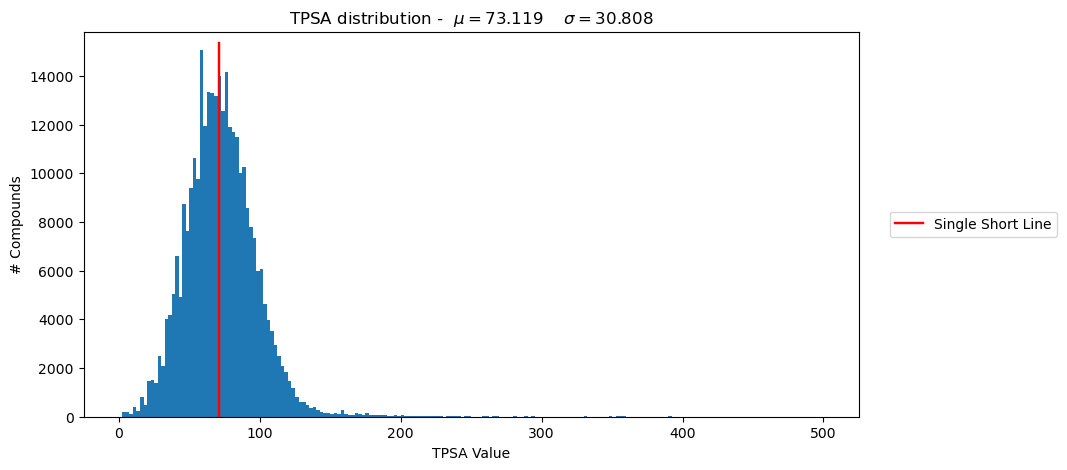

In [259]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
num_bins = 200
# fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,5))
sigma = df_train.Metadata_TPSA.std()
mu = df_train.Metadata_TPSA.mean()
med = df_train.Metadata_TPSA.median()
# the histogram of the data
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt.hist(df_train.Metadata_TPSA, num_bins, density=False, range=[0, 500],)
# p1 = [(med, 710), (6.0, 605)]
# _ = plt.vlines(x=med, ymin=10, ymax=17000, colors='red', linestyles='-', lw=1.75, label='Single Short Line')
_ = plt.axvline(x=med, ymin=0, ymax=.97, color='red', linestyle='-', lw=1.75, label='Single Short Line')
_ = plt.xlabel('TPSA Value');
_ = plt.ylabel('# Compounds');
_ = plt.title(fr'TPSA distribution -  $\mu={mu:.3f}$    $\sigma={sigma:.3f}$')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# axs[1].hist(dist2, bins=n_bins)
plt.show()

### Stratified CV data splits

In [260]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [261]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
# n_points = 100
# X = rng.randn(100, 10)

# percentiles_classes = [0.1, 0.3, 0.6]
# y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [ ]:
# Generate uneven groups

# group_prior = rng.dirichlet([2] * 10)
# group_prior.sum()
# group_prior

# groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
# groups.shape
# groups

In [ ]:
groups = np.repeat(0, train_X.shape[0])
groups.shape

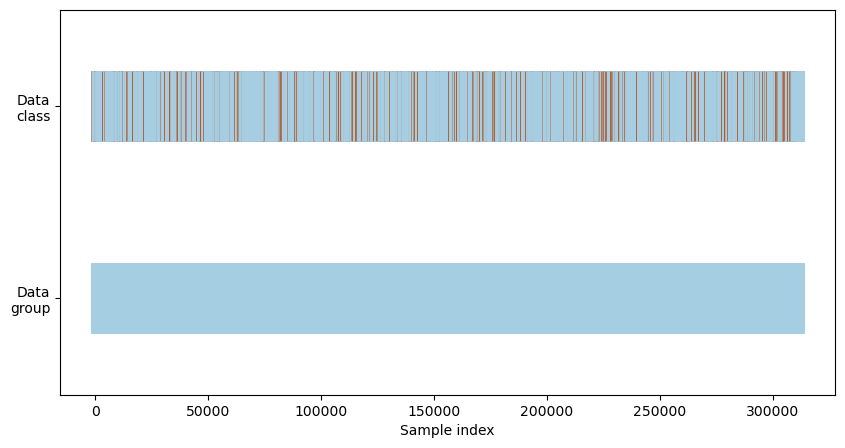

In [84]:
visualize_groups(train_y, groups, "no groups")

In [88]:
n_splits = 5
groups = None

/tmp/ipykernel_4107164/1298143750.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

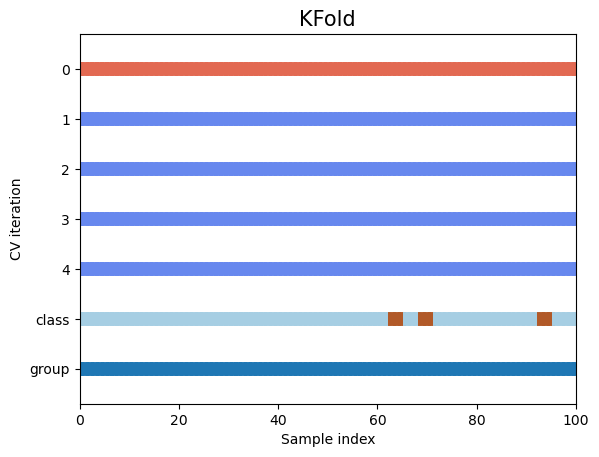

In [89]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, train_X, train_y, groups, ax, n_splits)

### Create balanced datasets

In [635]:
bal_train_X, bal_train_y = balance_datasets(train_X, train_y, ratio = 1)
bal_train_X_2, bal_train_y_2 = balance_datasets(train_X, train_y, ratio = 2)


 Take 12388 samples from total of 12388 negative training samples
 Take 12388 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 37164  Total len: 74328

 X :  Min: -27.6719    Max: 23.7271   Mean: 0.0016  Std: 1.0157
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 12388 samples from total of 12388 negative training samples
 Take 24776 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 74328  Total len: 111492

 X :  Min: -27.3326    Max: 26.3826   Mean: 0.0014  Std: 1.0076
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


In [636]:
bal_test_X, bal_test_y = balance_datasets(test_X, test_y, ratio = 1)
bal_test_X_2, bal_test_y_2 = balance_datasets(test_X, test_y, ratio = 2)


 Take 1388 samples from total of 1388 negative training samples
 Take 1388 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 4164  Total len: 8328

 X :  Min: -16.9431    Max: 19.0416   Mean: 0.0030  Std: 1.0028
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 1388 samples from total of 1388 negative training samples
 Take 2776 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 8328  Total len: 12492

 X :  Min: -18.7677    Max: 20.9524   Mean: 0.0015  Std: 0.9780
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


# Model definitions

# **[SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)**

Intuitively, the `gamma` parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The `gamma`parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The `C`parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words`C` behaves as a regularization parameter in the SVM.

## Parameters

In [26]:
try:
    del X_DATA, Y_DATA
except:
    pass
# train_y.head()

In [ ]:
# ESTIMATORS_FILENAME = f'PFP_SVM_embeddings_bits_over60_20241106_0700_parmsearch.pkl'
# METRICS_FILENAME = f'PFP_SVM_embeddings_bits_over60_20241106_0700_parmsearch_metrics.csv'

In [27]:
X_DATA = df_train_x.iloc[:, 11:]    ## bal_train_X
X_DATA
X_TEST = df_test_x.iloc[:, 11:]
X_TEST

,Feature_000,Feature_001,Feature_002,Feature_003,Feature_004,Feature_005,Feature_006,Feature_007,Feature_008,Feature_009,...,Feature_240,Feature_241,Feature_242,Feature_243,Feature_244,Feature_245,Feature_246,Feature_247,Feature_248,Feature_249
0,-0.015171,0.019367,0.028378,-0.016473,0.000907,0.000136,0.004825,-0.037934,-0.062155,-0.006528,...,0.009390,-0.008253,-0.037940,-0.016286,0.022038,0.005269,-0.018263,0.012688,-0.054655,0.004202
1,-0.010611,0.055484,0.074405,0.012844,-0.054465,-0.073002,0.032855,-0.061387,-0.149656,-0.119751,...,0.095957,0.040152,-0.005584,0.046152,-0.024817,0.049557,-0.078429,0.029078,-0.124861,0.021048
2,-0.034933,0.035995,0.057973,-0.034025,-0.006909,0.003759,0.004729,-0.072771,-0.125197,-0.009123,...,0.017318,-0.012258,-0.079632,-0.032763,0.054452,0.009448,-0.038036,0.030926,-0.111577,0.015640
3,-0.060865,0.105364,0.081075,-0.089675,0.001371,-0.018347,0.100143,0.004229,-0.168487,-0.065840,...,-0.114507,0.006824,-0.183686,0.006500,-0.066820,0.013238,-0.087850,-0.010228,-0.111716,-0.066975
4,-0.017895,0.029566,0.021643,-0.026001,0.001391,-0.007012,0.028064,0.005878,-0.042325,-0.021293,...,-0.035176,0.004032,-0.049694,0.004337,-0.024952,0.003663,-0.024778,-0.007309,-0.026831,-0.021770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277195,-0.000663,0.000106,-0.001281,-0.000529,0.001847,0.001724,-0.000201,-0.003414,0.001782,0.000404,...,0.001871,0.000387,-0.000532,-0.000985,0.002243,-0.001190,0.002249,0.001333,-0.001061,-0.000294
277196,-0.000814,0.000313,-0.001819,-0.000853,0.002900,0.002588,-0.000765,-0.005196,0.002887,0.000554,...,0.002895,0.000394,-0.001226,-0.001490,0.003483,-0.002166,0.003738,0.002156,-0.001370,-0.000499
277197,0.039051,0.002255,-0.013961,-0.017522,-0.006783,-0.036817,-0.041606,-0.026354,0.060860,0.058716,...,0.078374,0.063444,0.129917,0.051093,0.011726,-0.021745,-0.050653,-0.016714,0.055179,0.020004
277198,0.033865,0.079092,-0.107640,0.085196,0.036734,-0.138652,-0.016204,-0.106429,0.062254,0.010809,...,0.271270,0.117052,0.444226,0.021117,-0.012003,-0.033863,-0.132913,-0.304590,-0.049435,-0.070351


,Feature_000,Feature_001,Feature_002,Feature_003,Feature_004,Feature_005,Feature_006,Feature_007,Feature_008,Feature_009,...,Feature_240,Feature_241,Feature_242,Feature_243,Feature_244,Feature_245,Feature_246,Feature_247,Feature_248,Feature_249
0,0.916451,0.872596,1.605941,-0.048202,0.390532,0.409812,-0.655648,-1.462573,0.143709,-0.054209,...,-0.518385,0.716023,-0.590375,2.141531,-1.800316,-0.172188,-0.072441,1.743561,1.466185,1.244473
1,0.719237,0.682143,1.551272,0.287570,0.318039,0.582101,-0.372718,-1.462299,0.030956,0.022026,...,-0.591034,0.550698,-0.636886,1.880710,-1.816228,-0.037780,-0.130082,1.685629,1.263643,0.943990
2,0.798004,0.805205,1.545128,0.241463,0.315389,0.497950,-0.449862,-1.470268,0.122954,-0.037246,...,-0.355327,0.605948,-0.733919,2.052279,-1.843459,-0.157140,-0.118316,1.835303,1.341295,0.968254
3,-0.134616,-0.200266,-0.109721,0.058983,-0.134415,-0.044743,-0.221009,0.147919,0.262348,-0.208570,...,0.132724,-0.171853,0.401244,-0.037833,0.000879,-0.071789,0.051848,-0.053514,0.171957,0.121377
4,-0.031706,-0.148909,-0.102415,0.078211,-0.046021,0.023729,-0.130609,0.044276,0.173374,-0.036158,...,0.087170,-0.024574,0.260385,-0.012428,0.086317,-0.071831,0.047108,0.024453,0.105712,0.071885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,0.165864,-0.253816,-0.244503,0.277046,0.047860,0.147268,-0.127380,-0.035903,0.443936,0.321162,...,0.137795,0.131801,0.281455,-0.004880,0.298354,-0.011975,0.249098,0.122328,0.279326,0.173874
12596,0.051572,-0.152540,-0.031808,0.170956,0.025151,0.050282,-0.035007,-0.025391,0.185056,0.219689,...,0.016096,0.096827,0.021602,-0.066104,0.215846,0.068682,0.075461,0.025770,0.146833,0.132271
12597,-0.013109,-0.010380,0.031994,-0.008713,-0.025707,-0.032357,-0.064948,-0.040382,-0.037646,-0.037369,...,0.089090,-0.034141,0.049892,-0.022626,0.008242,0.008548,-0.012342,-0.017410,-0.045713,0.028342
12598,0.007677,-0.029839,0.009657,0.025732,-0.036984,-0.016097,-0.066608,-0.027636,0.016297,-0.034339,...,0.115197,-0.066165,0.072447,-0.020661,0.028276,0.005337,0.022535,-0.031815,-0.022689,0.010540


In [28]:
Best_Estimators = []
df_metrics = pd.DataFrame()

In [29]:
RANDOM_STATE = 6666
NUM_JOBS = 1


In [30]:
# Y_INDEX = 17
Y_DATA = df_train_y ## .iloc[:, Y_INDEX + Y_OFFSET] ## bal_train_y

In [25]:
svm_grid_parameters_0 = [
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['linear']},
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['rbf']},
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'gamma': [100,10,1,1e-1,1e-2, 1e-3], 'kernel': ['rbf']},
 ]

# svm_grid_parameters_1 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel' : ['linear'] }
# svm_grid_parameters_1 = {'C': [1], 'gamma': [1e-1], 'kernel' : ['linear'] }

# svm_grid_parameters_2 = {'C': [1, 10], 'kernel': ['linear']}
# svm_grid_parameters_2 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel': ['rbf']}

# svm_grid_parameters_3 = { 'C': [1, 10, 100],'gamma': [10,1,1e-1,1e-2]}
# svm_grid_parameters_3 = { 'C': [1, 10, 100], 'kernel': ['rbf']}

# svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1, 1.0e-1, 1.0e-2, ]}
# svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1.0e-3, 1.0e-4, 1.0e-5, ]}
# svm_grid_parameters = { 'C': [10], 'kernel': ['rbf'],'gamma': [1.0e-6, 1.0e-7, 1.0e-8,]}
# svm_grid_parameters = {'C': [0.1, 1, 10, 100, 200], 'kernel': ['rbf']}
svm_grid_parameters = {'C': [0.001, .01, 0.1, 1, 10], 'kernel': ['rbf']}
# svm_grid_parameters = {'C': [100, 500, 1000], 'kernel': ['rbf']}

In [32]:
PARM_SET = svm_grid_parameters
PARM_SET
RANDOM_STATE
# PARM_SET


{'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']}

6666

## Training

In [35]:
NUM_JOBS = 1
# X_DATA = bal_train_X
# Y_DATA = bal_train_y

In [36]:
svc = SVC(random_state =42, max_iter = 10000, tol = 1e-5, cache_size = 400, class_weight='balanced')

In [ ]:
vt_svm = model_selection(svc, PARM_SET, X_DATA, Y_DATA, scoring = 'roc_auc', cv=4, GridSearch = True, n_jobs=NUM_JOBS,  verbose = 3)

 verbose is 3
 params_grid: {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']}
 scoring    : roc_auc     cv:  4   n_jobs: 1   gridsearch: True    n_iter: 20   refit: True   
Fitting 4 folds for each of 5 candidates, totalling 20 fits


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/4] END ...............C=0.001, kernel=rbf;, score=0.497 total time=17.6min


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/4] END ...............C=0.001, kernel=rbf;, score=0.501 total time=18.5min


In [57]:
## Save best estimator and metrics
## -------------------------------------------------------

_tmp_df = pd.DataFrame(vt_svm.cv_results_)
# _tmp_df['Y_bit'] = selected_label_indices[Y_INDEX]
_tmp_df['random_seed'] = RANDOM_STATE
# reordered_col_names = ['Y_bit',
reordered_col_names = ['rank_test_score', 'param_C', 'param_solver', 'mean_test_score', 'std_test_score', 
                       'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_fit_time',
                       'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'random_seed']
_tmp_df = _tmp_df[reordered_col_names]
_tmp_df

,rank_test_score,param_C,param_solver,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,random_seed
0,1,0.11,lbfgs,0.608783,0.003347,0.605765,0.605514,0.610309,0.613546,38.472169,1.752602,0.072158,0.005986,"{'C': 0.11, 'solver': 'lbfgs'}",6666
1,2,0.1,lbfgs,0.608536,0.003313,0.605540,0.605282,0.610108,0.613213,31.851046,2.662029,0.069145,0.006310,"{'C': 0.1, 'solver': 'lbfgs'}",6666
2,3,0.075,lbfgs,0.608012,0.003433,0.604959,0.604550,0.609747,0.612791,25.553318,5.924446,0.064963,0.011648,"{'C': 0.075, 'solver': 'lbfgs'}",6666
3,4,0.05,lbfgs,0.607228,0.003484,0.604213,0.603597,0.609108,0.611996,17.563865,4.341509,0.063868,0.016948,"{'C': 0.05, 'solver': 'lbfgs'}",6666
4,5,0.025,lbfgs,0.606165,0.003649,0.603303,0.602108,0.608095,0.611153,23.462848,2.184836,0.097467,0.011414,"{'C': 0.025, 'solver': 'lbfgs'}",6666
5,6,0.0125,lbfgs,0.604868,0.003902,0.601954,0.600465,0.606757,0.610295,18.944685,1.509081,0.091296,0.007215,"{'C': 0.0125, 'solver': 'lbfgs'}",6666


#### Metric results

In [ ]:
# Best parameters set found on development set: {'C': 10, 'kernel': 'rbf'}
# Best score: 0.5378465362878473
# Grid scores on development set:

# 0.50235 (+/-0.031) for {'C': 1, 'kernel': 'rbf'}
# 0.53181 (+/-0.010) for {'C': 5, 'kernel': 'rbf'}
### 0.53785 (+/-0.008) for {'C': 10, 'kernel': 'rbf'}
### 0.53836 (+/-0.009) for {'C': 10, 'kernel': 'rbf'}
# 0.52558 (+/-0.010) for {'C': 15, 'kernel': 'rbf'}
# 0.51977 (+/-0.027) for {'C': 20, 'kernel': 'rbf'}
# 0.52734 (+/-0.028) for {'C': 25, 'kernel': 'rbf'}
# 0.53087 (+/-0.011) for {'C': 30, 'kernel': 'rbf'}
### 0.53761 (+/-0.014) for {'C': 30, 'kernel': 'rbf'}
# 0.53227 (+/-0.014) for {'C': 50, 'kernel': 'rbf'}
# 0.51949 (+/-0.011) for {'C': 70, 'kernel': 'rbf'}
# 0.53222 (+/-0.006) for {'C': 90, 'kernel': 'rbf'}
# 0.52077 (+/-0.022) for {'C': 100, 'kernel': 'rbf'}

# Best parameters set found on development set: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
# Best score: 0.5263117855594914
# Grid scores on development set:

# 0.48997 (+/-0.005) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
# 0.48441 (+/-0.002) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
# 0.52631 (+/-0.016) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
# 0.52721 (+/-0.007) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.53590 (+/-0.010) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.54687 (+/-0.011) for {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
# 0.54837 (+/-0.010) for {'C': 10, 'gamma': 1e-06, 'kernel': 'rbf'}
### 0.54872 (+/-0.011) for {'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'}
# 0.54796 (+/-0.012) for {'C': 10, 'gamma': 1e-08, 'kernel': 'rbf'}
 


In [640]:
vt_svm
vt_svm.best_estimator_
vt_svm.best_index_
vt_svm.best_params_
vt_svm.best_score_
vt_svm.classes_
vt_svm.cv
vt_svm.cv_results_
vt_svm.decision_function
vt_svm.error_score
vt_svm.estimator
vt_svm.fit
vt_svm.get_metadata_routing()
print('-'*40)
print(f"vt_svm parameters: ")
print('-'*40)
vt_svm.get_params()
# vt_svm.inverse_transform

GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

SVC(C=100, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)

0

{'C': 100, 'kernel': 'rbf'}

0.5360226792539031

array([0, 1], dtype=uint8)

4

{'mean_fit_time': array([205.12652862, 243.32209796, 225.83543795]),
 'std_fit_time': array([ 6.79211394, 18.80770631, 34.98232562]),
 'mean_score_time': array([88.93056607, 91.10064435, 88.03145939]),
 'std_score_time': array([1.21205485, 1.97996244, 3.45450594]),
 'param_C': masked_array(data=[100, 500, 1000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 100, 'kernel': 'rbf'},
  {'C': 500, 'kernel': 'rbf'},
  {'C': 1000, 'kernel': 'rbf'}],
 'split0_test_score': array([0.54505406, 0.52896171, 0.52896171]),
 'split1_test_score': array([0.52928611, 0.53277688, 0.53277688]),
 'split2_test_score': array([0.52812428, 0.5412952 , 0.5412952 ]),
 'split3_test_score': array([0.54162626, 0.52158292, 0.52158292]),
 'mean_test_score': array([0.53602268, 0.53115418, 0.53115418]),
 '

<bound method BaseSearchCV.decision_function of GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)>

nan

SVC(cache_size=400, class_weight='balanced', max_iter=10000, random_state=42,
    tol=1e-05)

<bound method BaseSearchCV.fit of GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)>

{'estimator': {'mapping': [{'callee': 'fit', 'caller': 'fit'}], 'router': {'fit': {'sample_weight': None}, 'score': {'sample_weight': None}}}, 'scorer': {'mapping': [{'callee': 'score', 'caller': 'score'}, {'callee': 'score', 'caller': 'fit'}], 'router': {}}, 'splitter': {'mapping': [{'callee': 'split', 'caller': 'fit'}], 'router': {}}}

----------------------------------------
vt_svm parameters: 
----------------------------------------


{'cv': 4,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 400,
 'estimator__class_weight': 'balanced',
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': 10000,
 'estimator__probability': False,
 'estimator__random_state': 42,
 'estimator__shrinking': True,
 'estimator__tol': 1e-05,
 'estimator__verbose': False,
 'estimator': SVC(cache_size=400, class_weight='balanced', max_iter=10000, random_state=42,
     tol=1e-05),
 'n_jobs': 5,
 'param_grid': {'C': [100, 500, 1000], 'kernel': ['rbf']},
 'pre_dispatch': 5,
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 3}

## Append best estimator and metrics

In [60]:
Best_Estimators
df_metrics.shape
df_metrics.sort_values('mean_test_score')

[(LogisticRegression(C=0.11, max_iter=10000, n_jobs=6, random_state=6666,
                     tol=1e-05),
  {'C': 0.11, 'solver': 'lbfgs'})]

(6, 15)

,rank_test_score,param_C,param_solver,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,random_seed
5,6,0.0125,lbfgs,0.604868,0.003902,0.601954,0.600465,0.606757,0.610295,18.944685,1.509081,0.091296,0.007215,"{'C': 0.0125, 'solver': 'lbfgs'}",6666
4,5,0.025,lbfgs,0.606165,0.003649,0.603303,0.602108,0.608095,0.611153,23.462848,2.184836,0.097467,0.011414,"{'C': 0.025, 'solver': 'lbfgs'}",6666
3,4,0.05,lbfgs,0.607228,0.003484,0.604213,0.603597,0.609108,0.611996,17.563865,4.341509,0.063868,0.016948,"{'C': 0.05, 'solver': 'lbfgs'}",6666
2,3,0.075,lbfgs,0.608012,0.003433,0.604959,0.604550,0.609747,0.612791,25.553318,5.924446,0.064963,0.011648,"{'C': 0.075, 'solver': 'lbfgs'}",6666
1,2,0.1,lbfgs,0.608536,0.003313,0.605540,0.605282,0.610108,0.613213,31.851046,2.662029,0.069145,0.006310,"{'C': 0.1, 'solver': 'lbfgs'}",6666
0,1,0.11,lbfgs,0.608783,0.003347,0.605765,0.605514,0.610309,0.613546,38.472169,1.752602,0.072158,0.005986,"{'C': 0.11, 'solver': 'lbfgs'}",6666


In [100]:
vt_logreg.best_estimator_, vt_logreg.best_params_

(LogisticRegression(C=0.11, max_iter=10000, n_jobs=6, random_state=6666,
                    tol=1e-05),
 {'C': 0.11, 'solver': 'lbfgs'})

In [59]:
df_metrics = pd.concat((df_metrics, _tmp_df))
Best_Estimators.append((vt_logreg.best_estimator_, vt_logreg.best_params_))

In [61]:
Best_Estimators
df_metrics.shape
df_metrics.sort_values('mean_test_score')

[(LogisticRegression(C=0.11, max_iter=10000, n_jobs=6, random_state=6666,
                     tol=1e-05),
  {'C': 0.11, 'solver': 'lbfgs'})]

(6, 15)

,rank_test_score,param_C,param_solver,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,random_seed
5,6,0.0125,lbfgs,0.604868,0.003902,0.601954,0.600465,0.606757,0.610295,18.944685,1.509081,0.091296,0.007215,"{'C': 0.0125, 'solver': 'lbfgs'}",6666
4,5,0.025,lbfgs,0.606165,0.003649,0.603303,0.602108,0.608095,0.611153,23.462848,2.184836,0.097467,0.011414,"{'C': 0.025, 'solver': 'lbfgs'}",6666
3,4,0.05,lbfgs,0.607228,0.003484,0.604213,0.603597,0.609108,0.611996,17.563865,4.341509,0.063868,0.016948,"{'C': 0.05, 'solver': 'lbfgs'}",6666
2,3,0.075,lbfgs,0.608012,0.003433,0.604959,0.604550,0.609747,0.612791,25.553318,5.924446,0.064963,0.011648,"{'C': 0.075, 'solver': 'lbfgs'}",6666
1,2,0.1,lbfgs,0.608536,0.003313,0.605540,0.605282,0.610108,0.613213,31.851046,2.662029,0.069145,0.006310,"{'C': 0.1, 'solver': 'lbfgs'}",6666
0,1,0.11,lbfgs,0.608783,0.003347,0.605765,0.605514,0.610309,0.613546,38.472169,1.752602,0.072158,0.005986,"{'C': 0.11, 'solver': 'lbfgs'}",6666


### Persist Model

In [62]:
ESTIMATORS_FILENAME = f'TPSA_SVM_embeddings_20241206_1500.pkl'
ESTIMATORS_FILENAME
METRICS_FILENAME = f'TPSA_SVM_embeddings_20241206_1500_metrics.csv'
METRICS_FILENAME

'TPSA_LogReg_embeddings_20241206_1300.pkl'

'TPSA_LogReg_embeddings_20241206_1300_metrics.csv'

In [63]:
save_to_pickle(Best_Estimators, '', ESTIMATORS_FILENAME, verbose = True)

 save_to_pickle(): save data to TPSA_LogReg_embeddings_20241206_1300.pkl


In [64]:
df_metrics.to_csv(METRICS_FILENAME)

### Load Model

In [78]:
MODEL_SAVE_PATH

'/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_tpsa_models/embedding_models'

In [79]:
MODEL_SAVE_PATH 
ESTIMATORS_FILENAME = f'TPSA_LogReg_embeddings_20241206_1300.pkl'
ESTIMATORS_FILENAME
METRICS_FILENAME = f'TPSA_LogReg_embeddings_20241206_1300_metrics.csv'
METRICS_FILENAME

'/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_tpsa_models/embedding_models'

'TPSA_LogReg_embeddings_20241206_1300.pkl'

'TPSA_LogReg_embeddings_20241206_1300_metrics.csv'

In [80]:
Best_Estimators = load_from_pickle(MODEL_SAVE_PATH, ESTIMATORS_FILENAME)
len(Best_Estimators)

In [448]:
Best_Estimators

print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print()
print(f"best_estimator_  :   {svm_estimators.best_estimator_}")
# print(f"best_index_  :       {svm_estimators.best_index_}")
# print(f"best_params_ :       {svm_estimators.best_params_}")
# print(f"best_score_  :       {svm_estimators.best_score_}")
# print(f"classes_     :       {svm_estimators.classes_}")
# print(f"cv           :       {svm_estimators.cv}")
# print()
# print(f"cv_results_  :       {svm_estimators.cv_results_}")
# print()
# print(f"error_score  :       {svm_estimators.error_score}")
# print(f"estimator    :       {svm_estimators.estimator}")

GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5,
             param_grid={'C': [0.1, 1, 10, 100, 200], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

parameters   :

best_estimator_  :   SVC(C=0.1, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)


## Metrics - `svm_estimators_1`

In [644]:
FILENAME = 'SVM_estimators_SNNL_1_BALANCED_RATIO_1.pkl'

svm_estimators = load_from_pickle('', FILENAME)

In [645]:
# print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print(f"best_estimator_  :   {svm_estimators.best_estimator_}")
print()
 

best_estimator_  :   SVC(C=100, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)



In [646]:
TEST_X, TEST_Y = bal_test_X, bal_test_y

In [647]:
y_pred = svm_estimators.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [648]:
bal_y_pred = svm_estimators.best_estimator_.predict(bal_test_X)
bal_y_pred.shape

(8328,)

In [657]:
label_counts( [("Ground Truth", test_y), ("Predictions", y_pred), ("Balanced Ground Truth", bal_test_y), ("Balanced Predictions", bal_test_y)])


 Ground Truth
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples: 34542
 Label 0:  24,179      % 70.00 
 Label 1:  10,363      % 30.00 

 Balanced Ground Truth
 Total samples: 8328
 Label 0:   4,164      % 50.00 
 Label 1:   4,164      % 50.00 

 Balanced Predictions
 Total samples: 8328
 Label 0:   4,164      % 50.00 
 Label 1:   4,164      % 50.00 



In [660]:
compute_metrics(test_y, y_pred, "Original test file")

 Original test file 
 ------------------ 
 Accuracy: 0.65998     Precision: 0.13423     Recall: 0.33405     F1: 0.19151 

 True + labels:          4164     ratio to total:  0.12055
 Predicted + labels:    10363     ratio to total:  0.30001
 True/Predicted Match:  22797     ratio to total:  0.65998


In [661]:
compute_metrics(bal_test_y, bal_y_pred, " 1:1 Balanced test file")

  1:1 Balanced test file 
 ----------------------- 
 Accuracy: 0.51393     Precision: 0.52176     Recall: 0.33405     F1: 0.40732 

 True + labels:          4164     ratio to total:  0.50000
 Predicted + labels:     2666     ratio to total:  0.32012
 True/Predicted Match:   4280     ratio to total:  0.51393


In [662]:
# plots_from_estimator(svm_estimators.best_estimator_, test_X, y_pred)
# plots_from_estimator(svm_estimators.best_estimator_, bal_test_X, bal_y_pred)

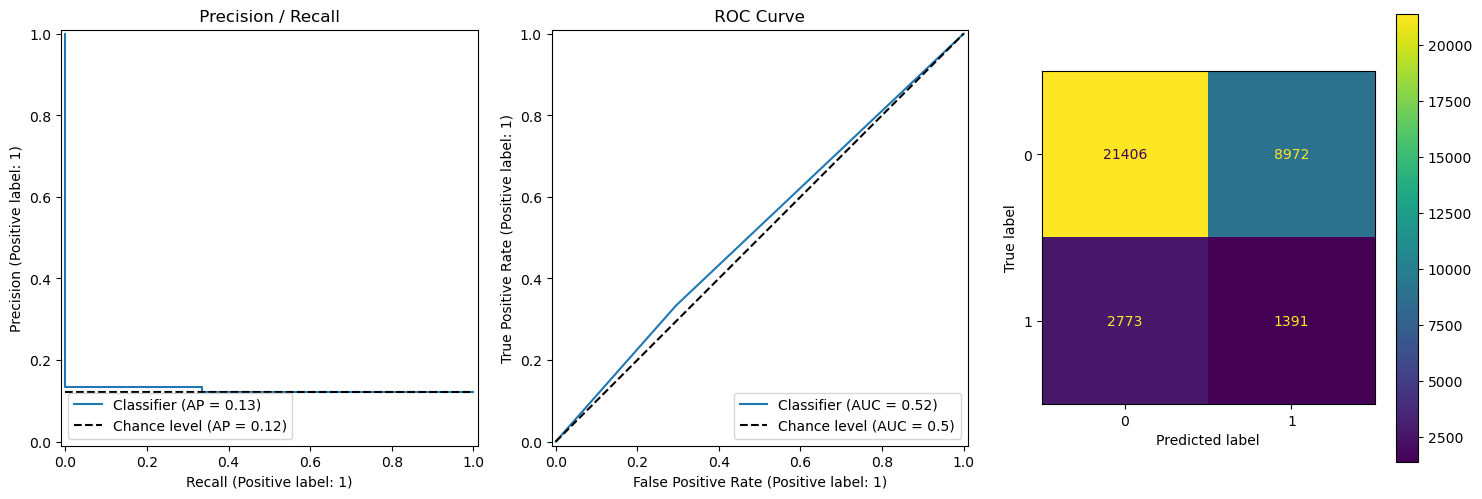

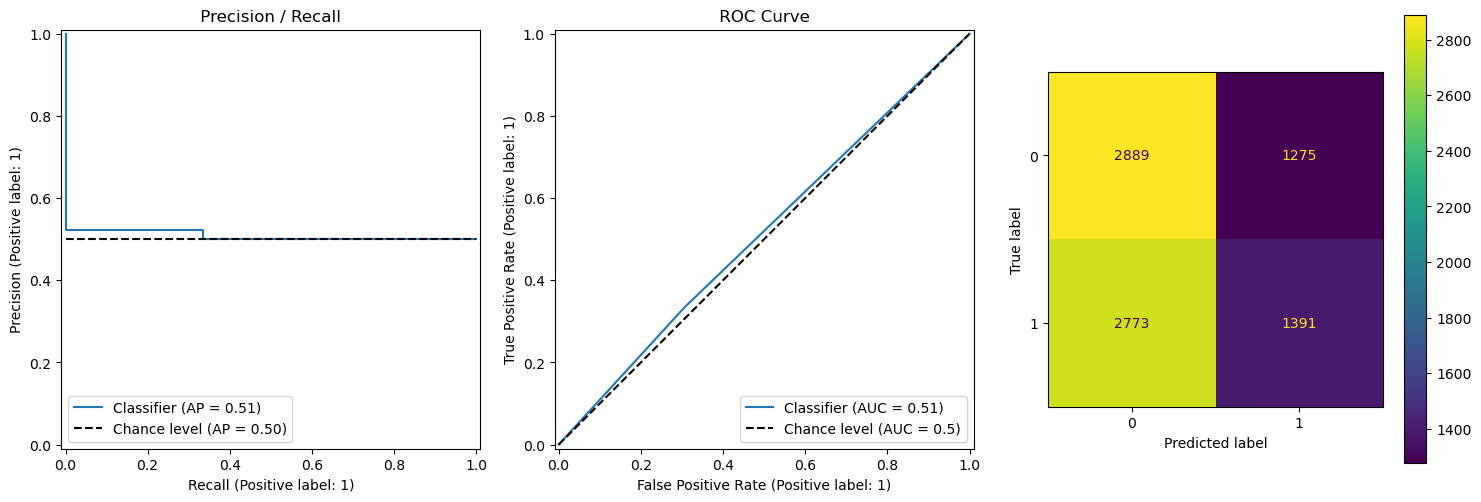

In [663]:
plots_from_predictions(test_y, y_pred)
plots_from_predictions(bal_test_y, bal_y_pred)